In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cadaster = pd.read_csv("data/cadaster_1808.csv")

In [3]:
list_family_names = pd.read_csv("data/Venice_list_of_names.csv", sep='\t"')

list_family_names = list_family_names.apply(lambda x: x.str.replace("\"", ""))

list_family_names.columns = [ 'family', '1808', 'Noble', 'Citoyen', 'famille.12e.siecle']

list_family_names.index = list_family_names.index.map(lambda x: x.replace("\"", ""))

list_family_names.to_csv("data/venice_families_cleaned.csv")

<ipython-input-3-646beb43eb24>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  list_family_names = pd.read_csv("data/Venice_list_of_names.csv", sep='\t"')


In [4]:
list_family_names

,family,1808,Noble,Citoyen,famille.12e.siecle
1,abramo,0,NA,0,0
2,acotanto,0,1,0,0
3,acquisti,1,1,0,0
4,adami,1,1,1,0
5,adoaldi,0,1,0,0
...,...,...,...,...,...
4459,cortonovich,1,0,0,0
4460,zanutta,1,0,0,0
4461,manfrini,1,0,0,0
4462,bardini,1,0,0,0


### Extracting the family names in capital letters


In [5]:
capitals = cadaster.parcelOwnerText.str.extract(r'(?P<Names>[A-Z]{2,})')
capitals['Names'].apply(lambda x : len(str(x).split(" ")))
capitals

,Names
0,PAGANI
1,TIEPOLO
2,PAGANI
3,BELLI
4,TIEPOLO
...,...
23423,PIAZZA
23424,DEMANIO
23425,REGIO
23426,DEMANIO


In [6]:
capitals.groupby('Names')['Names'].count().sort_values(ascending=False)

Names
CITTA         652
COMUNE        413
MOROSINI      280
CONTARINI     245
CORNER        218
             ... 
PICAZZO         1
GUERINI         1
PICCIOLI        1
GUELLACASA      1
LOCATELLII      1
Name: Names, Length: 2196, dtype: int64

In [7]:
df = capitals[capitals['Names'].str.lower().isin(list_family_names.family)]

In [8]:
df.groupby('Names')['Names'].count().sort_values(ascending=False)

Names
CITTA        652
COMUNE       413
MOROSINI     280
CONTARINI    245
CORNER       218
            ... 
PICAZZO        1
GUERINI        1
PICCIOLI       1
BUSSELLA       1
LIVIO          1
Name: Names, Length: 2185, dtype: int64

In [9]:
public_names = 'citta|demanio|chiesa|piazza|ministero|comune|societa|congregazione|di'
non_public = df[~df.Names.str.contains(public_names, na=False, case=False)]
name_count_cadaster = non_public.groupby('Names')['Names'].count().sort_values(ascending=False)

In [10]:
name_count_cadaster.to_csv('data/names_cadaster.csv')

## Catastici

In [11]:
catastici = pd.read_csv('data/catastici_1741_cleaned.csv')

In [12]:
family_name_options = list_family_names['family'].values

catastici['entryOwnerText_l'] = catastici['entryOwnerText'].apply(lambda x: str(x).lower())
catastici['entryTenantText_l'] = catastici['entryTenantText'].apply(lambda x: str(x).lower())



In [13]:
# we will use a fuzzy ratio to extract the name
from fuzzywuzzy import fuzz, process

top_3_names = catastici['entryOwnerText_l'].apply(lambda x: process.extract(x,family_name_options, scorer=fuzz.token_set_ratio, limit = 3))


ModuleNotFoundError: No module named 'fuzzywuzzy'

In [14]:
tenant_name = catastici['entryTenantText_l'].apply(lambda x: process.extractOne(x,family_name_options, scorer=fuzz.token_set_ratio))


NameError: name 'process' is not defined

In [15]:
tenant_name = pd.read_csv("tenant_names.csv")
top_3_names = pd.read_csv("top_3_names.csv")

In [16]:
# tenant_name.to_csv("tenant_names.csv")

In [17]:
tenant_name = tenant_name.drop("Unnamed: 0", axis = 1)
top_3_names = top_3_names.drop("Unnamed: 0", axis = 1)

In [18]:
tenant_name['entryTenantText_l']= tenant_name['entryTenantText_l'].apply(lambda x: eval(x))
catastici['tenant'] = pd.DataFrame(tenant_name)

In [19]:
top_3_names['entryOwnerText_l']= top_3_names['entryOwnerText_l'].apply(lambda x: eval(x))


In [20]:
owner_3 = ['owner_name1','owner_name2','owner_name3']
catastici[owner_3] = pd.DataFrame(top_3_names)['entryOwnerText_l'].apply(lambda x: pd.Series(x))

In [21]:
for col in owner_3:
    catastici[col] = catastici[col].apply(lambda x: x[0] if x[1] > 95 else None)
    catastici[col] = catastici[col].apply(lambda x: x if x != 'di' and x != 'de' else None)

In [22]:
catastici['tenant'] = catastici['tenant'].apply(lambda x: x[0])

In [23]:
melted = catastici.melt(id_vars = ['id', 'entryId', 'entryOwnerText', 'entryTenantText',
       'entryCategoryText', 'rent', 'cadaster1808Correspondance', 'toponym',
       'entryCategories', 'cadaster1808ClosestParcel', 'position',
       'entryOwnerText_l','tenant','entryTenantText_l']).dropna(subset=['value'])

In [24]:
melted['family_owner_count'] = melted.groupby('value')['id'].transform('count')

In [25]:
melted['family_tenant_count'] = melted.groupby('tenant')['id'].transform('count')

In [26]:
melted['family_tenant_count']

2         47
3         42
4         18
5        155
6         17
        ... 
29136     30
29137      4
29138     68
29139     45
29164    843
Name: family_tenant_count, Length: 12689, dtype: int64

In [27]:
cata2 = pd.read_csv('cata2.csv')

In [28]:
cata3 = cata2[['cadaster1808Correspondance','area','parcelNumber']].drop_duplicates().merge(melted, on = 'cadaster1808Correspondance')

In [29]:
cata3['ownerAreaSum'] = cata3.groupby('value')['area'].transform('sum')
cata3['family_area_mean'] = cata3['ownerAreaSum'] / cata3['family_owner_count']


In [30]:
melted[['category1','category2','category3']] = melted['entryCategories'].apply(lambda x: eval(x)).apply(pd.Series)

In [31]:
melted2 = melted.melt(id_vars=  ['id', 'entryId', 'entryOwnerText', 'entryTenantText',
       'entryCategoryText', 'rent', 'cadaster1808Correspondance', 'toponym',
       'entryCategories', 'cadaster1808ClosestParcel', 'position',
       'entryOwnerText_l','tenant','entryTenantText_l','variable','value',
                                'family_owner_count','family_tenant_count'], value_name = 'category').dropna(subset=['category'])

In [32]:
type_of_ownership = melted2.groupby(['value','category','entryId'])['id'].count().reset_index()

In [33]:
vals = type_of_ownership[type_of_ownership['value'] == 'morosini'].groupby("category")['entryId'].nunique()

<ipython-input-34-d2e9234959c8>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(vals.index,rotation = 90)


[Text(0, 0, 'housing'),
 Text(1, 0, 'storage'),
 Text(2, 0, 'shop'),
 Text(3, 0, 'hospitality'),
 Text(4, 0, 'entertainment'),
 Text(5, 0, 'palace')]

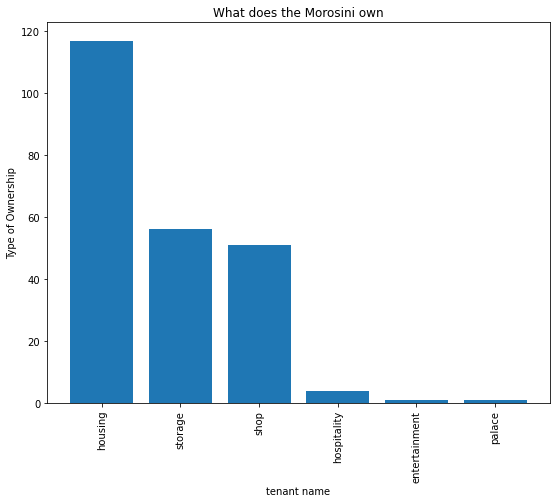

In [34]:
# for_plot = morosini.sort_values(by = 'proportion_of_rentals',ascending=False).head(20)
vals = vals.sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(9,7))
ax.bar(vals.index,vals.values)
ax.set_xlabel("tenant name")
ax.set_ylabel("Type of Ownership")
ax.set_title("What does the Morosini own")
ax.set_xticklabels(vals.index,rotation = 90)

In [42]:
vals.to_json('morosini.json', orient='index')

In [43]:
vals_contarini = type_of_ownership[type_of_ownership['value'] == 'contarini'].groupby("category")['entryId'].nunique()

In [45]:
vals_contarini.to_json('contarini.json', orient='index')


In [47]:
morosini = melted[melted['value'] == 'morosini'].groupby('tenant').agg({'id':'count','family_tenant_count':'mean'})

In [48]:
morosini['proportion_of_rentals'] = morosini['id'] / morosini['family_tenant_count']

<ipython-input-37-d1051a1a3bbb>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(for_plot.index,rotation = 90)


[Text(0, 0, 'ronzoni'),
 Text(1, 0, 'gidoni'),
 Text(2, 0, 'grassianceli'),
 Text(3, 0, 'greco'),
 Text(4, 0, 'brini'),
 Text(5, 0, 'agrinali'),
 Text(6, 0, 'bocchini'),
 Text(7, 0, 'epis'),
 Text(8, 0, 'coreggio'),
 Text(9, 0, 'gagio'),
 Text(10, 0, 'gerlin'),
 Text(11, 0, 'maistrorso'),
 Text(12, 0, 'persego'),
 Text(13, 0, 'boniol'),
 Text(14, 0, 'mazzamano'),
 Text(15, 0, 'satelico'),
 Text(16, 0, 'megliorini'),
 Text(17, 0, 'morari'),
 Text(18, 0, 'pagan'),
 Text(19, 0, 'stae')]

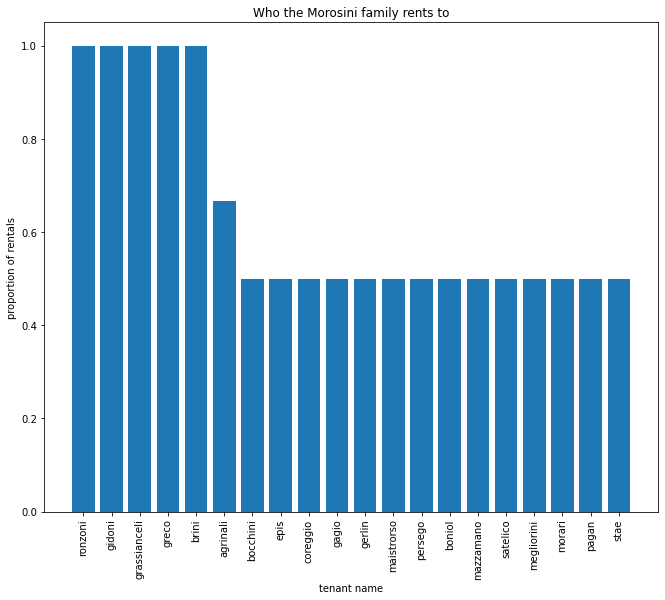

In [37]:
for_plot = morosini.sort_values(by = 'proportion_of_rentals',ascending=False).head(20)
fig, ax = plt.subplots(figsize=(11,9))
ax.bar(for_plot.index,for_plot['proportion_of_rentals'])
ax.set_xlabel("tenant name")
ax.set_ylabel("proportion of rentals")
ax.set_title("Who the Morosini family rents to")
ax.set_xticklabels(for_plot.index,rotation = 90)

In [51]:
contarini = melted[melted['value'] == 'contarini'].groupby('tenant').agg({'id':'count','family_tenant_count':'mean'})

In [64]:
contarini.drop('id', axis=1).sort_values(by='family_tenant_count', ascending=False).head(10).to_json('contarini_top_10.json')

In [38]:
melted.groupby('value').agg({''})

AttributeError: 'SeriesGroupBy' object has no attribute ''

In [41]:
morosini.to_json('morosini.json', orient='index')

In [ ]:
#Getting all owner rows with only two words (hoping that it's name and surname)
name_surname = catastici.entryOwnerText.apply(lambda x: len(str(x).split(' ')) == 2)

In [ ]:
catastici[name_surname].groupby('entryOwnerText')['id'].count().sort_values(ascending=False)

In [ ]:
catastici_names = catastici[name_surname]

In [ ]:
catastici_names['owner_surname'] = catastici_names.entryOwnerText.apply(lambda x: str(x).split()[1])
catastici_names['owner_name'] = catastici_names.entryOwnerText.apply(lambda x: str(x).split()[0])

In [ ]:
catastici_names

In [ ]:
catastici_names.to_csv('data/names_catastici.csv')

In [ ]:
name_count_catastici = catastici_names.groupby('owner_surname')['id'].count().sort_values(ascending=False)

In [ ]:
name_count_catastici

## Which families own the most properties?

In [ ]:
top_fams_catastici = name_count_catastici.head(25)
top_fams_catastici

In [ ]:
top_fams_cadaster = name_count_cadaster.head(25)
top_fams_cadaster

In [ ]:
contarini = catastici_names[catastici_names.owner_surname.apply(lambda x : 'Contarini' in x)]

In [ ]:
contarini

In [ ]:
contarini.to_json("data/contarini.json")

In [ ]:
contarini_boys = contarini.groupby('owner_name')['id'].count().sort_values(ascending=False)
contarini_boys